<a href="https://colab.research.google.com/github/Malik-Raheel/Trading-Strategies/blob/main/4_hour_timeframe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade ccxt pandas numpy scikit-learn tensorflow pandas-ta matplotlib plotly

  Using cached numpy-2.3.4-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)


In [5]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import ccxt
import logging
import time
from datetime import datetime, timedelta
import warnings
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Initialize Exchange
exchange = ccxt.kucoin({
    'rateLimit': 100,
    'enableRateLimit': True,
    'timeout': 30000,
})

class Enhanced4HTradingStrategy:
    def __init__(self, initial_capital=10000):
        self.initial_capital = initial_capital
        self.commission = 0.001

    def fetch_multi_timeframe_data(self, symbol, days=90):
        """Fetch data for multiple timeframes with 1D as primary higher timeframe."""
        timeframes = {
            '1D': '1d',    # Primary higher timeframe for trend
            '4H': '4h',    # Main trading timeframe
            '1H': '1h',    # For entry confirmation
        }

        data = {}
        for tf_name, tf_code in timeframes.items():
            try:
                df = self.fetch_historical_data_from_kucoin(symbol, tf_code, days)
                if not df.empty:
                    df = self.add_advanced_indicators(df, tf_name)
                    data[tf_name] = df
                time.sleep(0.1)
            except Exception as e:
                logging.warning(f"Error fetching {tf_name} data: {e}")
                continue

        return data

    def fetch_historical_data_from_kucoin(self, symbol, timeframe='4h', days=90):
        """Fetch real historical data from Kucoin."""
        try:
            since = exchange.parse8601((datetime.now() - timedelta(days=days)).isoformat())
            all_ohlcv = []

            current_since = since
            for _ in range(20):
                try:
                    ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since=current_since, limit=1000)
                    if not ohlcv:
                        break

                    all_ohlcv.extend(ohlcv)
                    current_since = ohlcv[-1][0] + 1
                    time.sleep(0.1)

                except Exception as e:
                    break

            if not all_ohlcv:
                return pd.DataFrame()

            df = pd.DataFrame(all_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            df.set_index('timestamp', inplace=True)
            df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].astype(float)

            df = df[~df.index.duplicated(keep='first')]
            df = df.sort_index()

            return df

        except Exception as e:
            logging.error(f"Error fetching data for {symbol}: {e}")
            return pd.DataFrame()

    def safe_ta_indicator(self, func, *args, **kwargs):
        """Safely calculate technical indicators with error handling."""
        try:
            result = func(*args, **kwargs)
            if result is not None and isinstance(result, pd.Series):
                return result.replace([np.inf, -np.inf], np.nan).fillna(method='ffill')
            return result
        except Exception as e:
            logging.warning(f"Indicator calculation failed: {e}")
            return None

    def add_advanced_indicators(self, df, timeframe):
        """Add comprehensive technical indicators with focus on OBV and volatility."""
        if df.empty or len(df) < 50:
            return df

        try:
            # Basic price indicators with safe initialization
            df['EMA_20'] = self.safe_ta_indicator(ta.ema, df['close'], length=20)
            df['EMA_50'] = self.safe_ta_indicator(ta.ema, df['close'], length=50)
            df['EMA_100'] = self.safe_ta_indicator(ta.ema, df['close'], length=100)
            df['SMA_20'] = self.safe_ta_indicator(ta.sma, df['close'], length=20)

            # Ensure EMA columns exist and have proper values
            for ema_col in ['EMA_20', 'EMA_50', 'EMA_100']:
                if ema_col not in df.columns or df[ema_col].isna().all():
                    df[ema_col] = df['close']  # Fallback to close price
                else:
                    df[ema_col] = df[ema_col].fillna(method='ffill').fillna(df['close'])

            # RSI with different parameters based on timeframe
            rsi_length = 14
            df['RSI'] = self.safe_ta_indicator(ta.rsi, df['close'], length=rsi_length)
            if 'RSI' in df.columns:
                df['RSI'] = df['RSI'].fillna(50)  # Default to neutral 50
                df['RSI_SMA'] = self.safe_ta_indicator(ta.sma, df['RSI'], length=5)

            # MACD
            macd_data = self.safe_ta_indicator(ta.macd, df['close'])
            if macd_data is not None:
                df['MACD'] = macd_data.get('MACD_12_26_9', 0)
                df['MACD_Signal'] = macd_data.get('MACDs_12_26_9', 0)
                df['MACD_Histogram'] = macd_data.get('MACDh_12_26_9', 0)

            # VOLATILITY INDICATORS (Key for 4H trading)
            # ATR for volatility
            df['ATR'] = self.safe_ta_indicator(ta.atr, df['high'], df['low'], df['close'], length=14)
            if 'ATR' in df.columns:
                df['ATR'] = df['ATR'].fillna(df['close'] * 0.01)  # Default 1% ATR
                df['ATR_pct'] = (df['ATR'] / df['close'] * 100)

            # Bollinger Bands with volatility measurement
            bb_data = self.safe_ta_indicator(ta.bbands, df['close'], length=20)
            if bb_data is not None:
                df['BB_upper'] = bb_data.get('BBU_20_2.0', df['close'] * 1.1)
                df['BB_middle'] = bb_data.get('BBM_20_2.0', df['close'])
                df['BB_lower'] = bb_data.get('BBL_20_2.0', df['close'] * 0.9)
                df['BB_width'] = (df['BB_upper'] - df['BB_lower']) / df['BB_middle']
                df['BB_position'] = (df['close'] - df['BB_lower']) / (df['BB_upper'] - df['BB_lower'])
                df['BB_squeeze'] = df['BB_width'] < df['BB_width'].rolling(50, min_periods=1).mean()

            # Keltner Channel for additional volatility context
            kc_data = self.safe_ta_indicator(ta.kc, df['high'], df['low'], df['close'], length=20)
            if kc_data is not None:
                df['KC_upper'] = kc_data.get('KCUe_20_2', df['close'] * 1.1)
                df['KC_lower'] = kc_data.get('KCLe_20_2', df['close'] * 0.9)
                df['KC_middle'] = kc_data.get('KCBe_20_2', df['close'])

            # OBV (On-Balance Volume) - ENHANCED
            df['OBV'] = self.safe_ta_indicator(ta.obv, df['close'], df['volume'])
            if 'OBV' in df.columns:
                df['OBV'] = df['OBV'].fillna(0)
                # OBV Moving averages for trend confirmation
                df['OBV_EMA_20'] = self.safe_ta_indicator(ta.ema, df['OBV'], length=20)
                df['OBV_EMA_50'] = self.safe_ta_indicator(ta.ema, df['OBV'], length=50)

                # Ensure OBV EMA columns exist
                for obv_ema in ['OBV_EMA_20', 'OBV_EMA_50']:
                    if obv_ema not in df.columns or df[obv_ema].isna().all():
                        df[obv_ema] = df['OBV']

                df['OBV_trend'] = np.where(df['OBV_EMA_20'] > df['OBV_EMA_50'], 1, -1)

                # OBV Breakouts
                df['OBV_high_20'] = df['OBV'].rolling(20, min_periods=1).max()
                df['OBV_low_20'] = df['OBV'].rolling(20, min_periods=1).min()
                df['OBV_breakout'] = np.where(df['OBV'] > df['OBV_high_20'].shift(1), 1,
                                            np.where(df['OBV'] < df['OBV_low_20'].shift(1), -1, 0))

            # Volume indicators
            df['volume_sma'] = self.safe_ta_indicator(ta.sma, df['volume'], length=20)
            if 'volume_sma' in df.columns:
                df['volume_sma'] = df['volume_sma'].fillna(df['volume'])
                df['volume_ratio'] = df['volume'] / df['volume_sma']

            # Additional momentum indicators for 4H trading
            adx_data = self.safe_ta_indicator(ta.adx, df['high'], df['low'], df['close'])
            if adx_data is not None:
                df['ADX'] = adx_data.get('ADX_14', 25)
            else:
                df['ADX'] = 25  # Default neutral ADX

            # Stochastic for momentum
            stoch = self.safe_ta_indicator(ta.stoch, df['high'], df['low'], df['close'])
            if stoch is not None:
                df['Stoch_K'] = stoch.get('STOCHk_14_3_3', 50)
                df['Stoch_D'] = stoch.get('STOCHd_14_3_3', 50)
            else:
                df['Stoch_K'] = 50
                df['Stoch_D'] = 50

            # Supertrend for trend identification
            supertrend = self.safe_ta_indicator(ta.supertrend, df['high'], df['low'], df['close'], length=10, multiplier=3)
            if supertrend is not None:
                df['Supertrend'] = supertrend.get('SUPERT_10_3.0', df['close'])
                df['Supertrend_Direction'] = supertrend.get('SUPERTd_10_3.0', 1)
            else:
                df['Supertrend'] = df['close']
                df['Supertrend_Direction'] = 1

            # Fill remaining NaN values
            df = df.fillna(method='ffill').fillna(method='bfill')

            return df
        except Exception as e:
            logging.error(f"Error adding indicators for {timeframe}: {e}")
            # Ensure basic columns exist
            for col in ['EMA_20', 'EMA_50', 'EMA_100', 'RSI', 'ATR', 'OBV']:
                if col not in df.columns:
                    df[col] = df['close'] if col != 'RSI' else 50
            return df

    def get_daily_trend_bias(self, data):
        """Get daily trend bias for 4H trading context with safe value access."""
        if '1D' not in data or data['1D'].empty:
            return "NEUTRAL"

        df_daily = data['1D']
        if len(df_daily) < 50:
            return "NEUTRAL"

        current_price = self.safe_get_value(df_daily, 'close', 0)
        ema_20 = self.safe_get_value(df_daily, 'EMA_20', current_price)
        ema_50 = self.safe_get_value(df_daily, 'EMA_50', current_price)
        ema_100 = self.safe_get_value(df_daily, 'EMA_100', current_price)

        # Safe comparison with fallback values
        try:
            ema_bullish = (ema_20 > ema_50 > ema_100 and current_price > ema_20)
            ema_bearish = (ema_20 < ema_50 < ema_100 and current_price < ema_20)
        except TypeError:
            # If any comparison fails, use neutral bias
            return "NEUTRAL"

        if ema_bullish:
            return "BULLISH"
        elif ema_bearish:
            return "BEARISH"
        else:
            return "NEUTRAL"

    def generate_4h_trading_signals(self, data):
        """Generate high-probability 4H trading signals with OBV and volatility focus."""
        if '4H' not in data or data['4H'].empty:
            return []

        df_4h = data['4H']
        if len(df_4h) < 50:
            return []

        signals = []
        current_price = self.safe_get_value(df_4h, 'close', 0)

        # Get daily trend bias
        daily_trend = self.get_daily_trend_bias(data)

        # 1. Trend Alignment with OBV Confirmation
        trend_signals = self.generate_trend_obv_signals(df_4h, current_price, daily_trend)
        signals.extend(trend_signals)

        # 2. Volatility Breakout with OBV
        volatility_signals = self.generate_volatility_breakout_signals(df_4h, current_price, daily_trend)
        signals.extend(volatility_signals)

        # 3. OBV Divergence Signals
        obv_signals = self.generate_obv_divergence_signals(df_4h, current_price, daily_trend)
        signals.extend(obv_signals)

        # 4. Multi-timeframe RSI Convergence
        rsi_signals = self.generate_multi_tf_rsi_signals(data, current_price, daily_trend)
        signals.extend(rsi_signals)

        # Filter signals by confidence and remove duplicates
        filtered_signals = self.filter_and_prioritize_signals(signals)

        return filtered_signals

    def generate_trend_obv_signals(self, df_4h, current_price, daily_trend):
        """Generate signals based on trend alignment with OBV confirmation."""
        signals = []

        # Safely get values with defaults
        ema_20 = self.safe_get_value(df_4h, 'EMA_20', current_price)
        ema_50 = self.safe_get_value(df_4h, 'EMA_50', current_price)
        obv_trend = self.safe_get_value(df_4h, 'OBV_trend', 0)
        obv_ema_20 = self.safe_get_value(df_4h, 'OBV_EMA_20', 0)
        obv_ema_50 = self.safe_get_value(df_4h, 'OBV_EMA_50', 0)
        volume_ratio = self.safe_get_value(df_4h, 'volume_ratio', 1)

        # Bullish Trend with OBV Confirmation
        if (current_price > ema_20 > ema_50 and
            obv_trend > 0 and
            obv_ema_20 > obv_ema_50):

            confidence = 0.75
            # Increase confidence if aligned with daily trend
            if daily_trend == "BULLISH":
                confidence = 0.85
            # Additional confirmation from volume
            if volume_ratio > 1.2:
                confidence = min(0.95, confidence + 0.1)

            signals.append(('TREND_OBV_BULLISH', 'LONG', confidence, [
                f"Price above EMAs",
                f"OBV trend bullish",
                f"Daily trend: {daily_trend}"
            ]))

        # Bearish Trend with OBV Confirmation
        elif (current_price < ema_20 < ema_50 and
              obv_trend < 0 and
              obv_ema_20 < obv_ema_50):

            confidence = 0.75
            if daily_trend == "BEARISH":
                confidence = 0.85
            if volume_ratio > 1.2:
                confidence = min(0.95, confidence + 0.1)

            signals.append(('TREND_OBV_BEARISH', 'SHORT', confidence, [
                f"Price below EMAs",
                f"OBV trend bearish",
                f"Daily trend: {daily_trend}"
            ]))

        return signals

    def generate_volatility_breakout_signals(self, df_4h, current_price, daily_trend):
        """Generate signals based on volatility breakouts with OBV confirmation."""
        signals = []

        # Safely get values
        bb_squeeze = self.safe_get_value(df_4h, 'BB_squeeze', False)
        bb_position = self.safe_get_value(df_4h, 'BB_position', 0.5)
        obv_breakout = self.safe_get_value(df_4h, 'OBV_breakout', 0)
        atr_pct = self.safe_get_value(df_4h, 'ATR_pct', 2.0)
        volume_ratio = self.safe_get_value(df_4h, 'volume_ratio', 1)

        # Low volatility breakout (BB squeeze)
        if bb_squeeze:
            # Bullish breakout with OBV confirmation
            if (bb_position > 0.7 and
                obv_breakout > 0 and
                volume_ratio > 1.5):

                confidence = 0.80
                if daily_trend == "BULLISH":
                    confidence = 0.90

                signals.append(('VOL_BREAKOUT_BULLISH', 'LONG', confidence, [
                    f"BB Squeeze breakout",
                    f"OBV confirmation",
                    f"High volume: {volume_ratio:.2f}",
                    f"ATR: {atr_pct:.2f}%"
                ]))

            # Bearish breakout with OBV confirmation
            elif (bb_position < 0.3 and
                  obv_breakout < 0 and
                  volume_ratio > 1.5):

                confidence = 0.80
                if daily_trend == "BEARISH":
                    confidence = 0.90

                signals.append(('VOL_BREAKOUT_BEARISH', 'SHORT', confidence, [
                    f"BB Squeeze breakout",
                    f"OBV confirmation",
                    f"High volume: {volume_ratio:.2f}",
                    f"ATR: {atr_pct:.2f}%"
                ]))

        return signals

    def generate_obv_divergence_signals(self, df_4h, current_price, daily_trend):
        """Generate signals based on OBV-Price divergence."""
        signals = []

        if 'OBV' not in df_4h.columns or len(df_4h) < 20:
            return signals

        # Look for divergences in the last 10 periods
        lookback = min(10, len(df_4h))

        try:
            # Bullish divergence: Price makes lower low, OBV makes higher low
            price_lows = df_4h['low'].tail(lookback)
            obv_lows = df_4h['OBV'].tail(lookback)

            if len(price_lows) < 2:
                return signals

            recent_price_low_idx = price_lows.idxmin()
            recent_obv_low_idx = obv_lows.idxmin()

            # Bullish divergence detection
            if (price_lows.iloc[-1] == price_lows.min() and
                obv_lows.iloc[-1] > obv_lows.iloc[-2] and
                df_4h.loc[recent_price_low_idx, 'low'] < df_4h['low'].iloc[-2] and
                df_4h.loc[recent_obv_low_idx, 'OBV'] > df_4h['OBV'].iloc[-2]):

                confidence = 0.70
                if daily_trend == "BULLISH":
                    confidence = 0.80
                rsi = self.safe_get_value(df_4h, 'RSI', 50)
                if rsi < 40:
                    confidence = min(0.90, confidence + 0.1)

                signals.append(('OBV_BULLISH_DIVERGENCE', 'LONG', confidence, [
                    "Price lower low, OBV higher low",
                    f"RSI: {rsi:.1f}"
                ]))

            # Bearish divergence: Price makes higher high, OBV makes lower high
            price_highs = df_4h['high'].tail(lookback)
            obv_highs = df_4h['OBV'].tail(lookback)

            recent_price_high_idx = price_highs.idxmax()
            recent_obv_high_idx = obv_highs.idxmax()

            if (price_highs.iloc[-1] == price_highs.max() and
                obv_highs.iloc[-1] < obv_highs.iloc[-2] and
                df_4h.loc[recent_price_high_idx, 'high'] > df_4h['high'].iloc[-2] and
                df_4h.loc[recent_obv_high_idx, 'OBV'] < df_4h['OBV'].iloc[-2]):

                confidence = 0.70
                if daily_trend == "BEARISH":
                    confidence = 0.80
                rsi = self.safe_get_value(df_4h, 'RSI', 50)
                if rsi > 60:
                    confidence = min(0.90, confidence + 0.1)

                signals.append(('OBV_BEARISH_DIVERGENCE', 'SHORT', confidence, [
                    "Price higher high, OBV lower high",
                    f"RSI: {rsi:.1f}"
                ])
            )
        except Exception as e:
            logging.warning(f"Error in OBV divergence detection: {e}")

        return signals

    def generate_multi_tf_rsi_signals(self, data, current_price, daily_trend):
        """Generate signals based on RSI convergence across timeframes."""
        signals = []

        rsi_values = {}
        for tf in ['4H', '1H', '1D']:
            if tf in data and not data[tf].empty and 'RSI' in data[tf].columns:
                rsi = self.safe_get_value(data[tf], 'RSI', 50)
                rsi_values[tf] = rsi

        if len(rsi_values) >= 2:
            # Bullish RSI convergence (oversold across timeframes)
            bullish_conditions = all(25 < rsi < 40 for rsi in rsi_values.values())
            # Bearish RSI convergence (overbought across timeframes)
            bearish_conditions = all(60 < rsi < 75 for rsi in rsi_values.values())

            if bullish_conditions:
                confidence = 0.75
                if daily_trend == "BULLISH":
                    confidence = 0.85

                signals.append(('MULTI_TF_RSI_BULLISH', 'LONG', confidence, [
                    f"RSI oversold convergence",
                    f"4H RSI: {rsi_values.get('4H', 'N/A')}",
                    f"1D RSI: {rsi_values.get('1D', 'N/A')}"
                ]))

            elif bearish_conditions:
                confidence = 0.75
                if daily_trend == "BEARISH":
                    confidence = 0.85

                signals.append(('MULTI_TF_RSI_BEARISH', 'SHORT', confidence, [
                    f"RSI overbought convergence",
                    f"4H RSI: {rsi_values.get('4H', 'N/A')}",
                    f"1D RSI: {rsi_values.get('1D', 'N/A')}"
                ]))

        return signals

    def filter_and_prioritize_signals(self, signals):
        """Filter and prioritize signals by confidence and remove conflicts."""
        if not signals:
            return []

        # Group by direction
        long_signals = [s for s in signals if s[1] == 'LONG']
        short_signals = [s for s in signals if s[1] == 'SHORT']

        # Take highest confidence signal for each direction
        best_long = max(long_signals, key=lambda x: x[2]) if long_signals else None
        best_short = max(short_signals, key=lambda x: x[2]) if short_signals else None

        filtered_signals = []

        # Only return signals with confidence > 0.7
        if best_long and best_long[2] > 0.7:
            filtered_signals.append(best_long)
        if best_short and best_short[2] > 0.7:
            filtered_signals.append(best_short)

        return filtered_signals

    def calculate_position_size(self, current_price, stop_loss, risk_per_trade=0.02, capital=10000):
        """Calculate position size with 2% risk per trade."""
        risk_amount = capital * risk_per_trade
        price_risk = abs(current_price - stop_loss)

        if price_risk == 0:
            return 0

        position_size = risk_amount / price_risk

        # Don't risk more than 5% of capital on any single trade
        max_position_value = capital * 0.05
        max_shares = max_position_value / current_price

        return min(position_size, max_shares)

    def safe_get_value(self, df, column, default=0):
        """Safely get value from DataFrame column."""
        if df is None or df.empty:
            return default
        if column in df.columns and len(df) > 0:
            value = df[column].iloc[-1]
            if pd.notna(value) and value is not None:
                return value
        return default

    def get_obv_trend_status(self, df_daily, obv_d):
        """Safely determine OBV trend status."""
        if df_daily is None or df_daily.empty or 'OBV' not in df_daily.columns or len(df_daily) < 5:
            return "NEUTRAL"

        try:
            if obv_d > self.safe_get_value(df_daily, 'OBV', obv_d, -5):
                return "BULLISH"
            elif obv_d < self.safe_get_value(df_daily, 'OBV', obv_d, -5):
                return "BEARISH"
            else:
                return "NEUTRAL"
        except:
            return "NEUTRAL"

    def analyze_symbol(self, symbol, days=90):
        """Complete analysis for a symbol with 4H trading signals."""
        print(f"\n🎯 {symbol} - 4H TRADING STRATEGY ANALYSIS")
        print("=" * 80)

        # Fetch multi-timeframe data
        data = self.fetch_multi_timeframe_data(symbol, days)
        if not data or '4H' not in data:
            print("❌ No data available")
            return None

        current_price = self.safe_get_value(data['4H'], 'close', 0)
        atr = self.safe_get_value(data['4H'], 'ATR', current_price * 0.02)

        # Generate signals
        signals = self.generate_4h_trading_signals(data)
        daily_trend = self.get_daily_trend_bias(data)

        # Display analysis
        self.display_4h_analysis(symbol, data, signals, current_price, atr, daily_trend)

        return {
            'symbol': symbol,
            'signals': signals,
            'current_price': current_price,
            'daily_trend': daily_trend,
            'data': data
        }

    def display_4h_analysis(self, symbol, data, signals, current_price, atr, daily_trend):
        """Display comprehensive 4H analysis results."""

        # Market Overview
        print(f"\n📊 4H MARKET OVERVIEW:")
        print(f"   Current Price: ${current_price:.4f}")
        print(f"   ATR: ${atr:.4f} ({atr/current_price*100:.2f}%)")
        print(f"   Daily Trend Bias: {daily_trend}")
        print(f"   Volatility: {'HIGH' if atr/current_price > 0.03 else 'MEDIUM' if atr/current_price > 0.015 else 'LOW'}")

        # Technical Indicators
        print(f"\n📈 TECHNICAL INDICATORS (4H):")
        if '4H' in data:
            df_4h = data['4H']

            # OBV Analysis
            obv = self.safe_get_value(df_4h, 'OBV', 0)
            obv_trend = self.safe_get_value(df_4h, 'OBV_trend', 0)
            obv_breakout = self.safe_get_value(df_4h, 'OBV_breakout', 0)

            print(f"   OBV Trend: {'BULLISH' if obv_trend > 0 else 'BEARISH' if obv_trend < 0 else 'NEUTRAL'}")
            print(f"   OBV Breakout: {'BULLISH' if obv_breakout > 0 else 'BEARISH' if obv_breakout < 0 else 'NONE'}")

            # Volatility Analysis
            bb_width = self.safe_get_value(df_4h, 'BB_width', 0)
            bb_squeeze = self.safe_get_value(df_4h, 'BB_squeeze', False)
            atr_pct = self.safe_get_value(df_4h, 'ATR_pct', 0)

            print(f"   BB Width: {bb_width:.4f} | Squeeze: {'YES' if bb_squeeze else 'NO'}")
            print(f"   ATR %: {atr_pct:.2f}%")

            # Momentum Indicators
            rsi = self.safe_get_value(df_4h, 'RSI', 50)
            macd = self.safe_get_value(df_4h, 'MACD', 0)
            volume_ratio = self.safe_get_value(df_4h, 'volume_ratio', 1)

            print(f"   RSI: {rsi:.1f} | MACD: {macd:.4f}")
            print(f"   Volume Ratio: {volume_ratio:.2f}x")

        # Trading Signals
        print(f"\n🎯 4H TRADING SIGNALS:")
        if signals:
            for signal_type, direction, confidence, conditions in signals:
                signal_emoji = "🟢" if direction == 'LONG' else "🔴"
                print(f"   {signal_emoji} {direction}: {signal_type}")
                print(f"      Confidence: {confidence:.1%}")
                print(f"      Conditions: {', '.join(conditions)}")

                # Calculate position details
                if direction == 'LONG':
                    stop_loss = current_price - (atr * 2)
                    take_profit = current_price + (atr * 3)
                else:
                    stop_loss = current_price + (atr * 2)
                    take_profit = current_price - (atr * 3)

                risk_reward = abs(take_profit - current_price) / abs(current_price - stop_loss)
                position_size = self.calculate_position_size(current_price, stop_loss)

                print(f"      Entry: ${current_price:.4f}")
                print(f"      Stop: ${stop_loss:.4f} | Target: ${take_profit:.4f}")
                print(f"      R:R: {risk_reward:.2f}:1 | Position: {position_size:.4f} units")
                print()
        else:
            print("   ❌ No high-probability 4H trading signals")
            print("   💡 Waiting for better setup...")

        # Daily Context
        print(f"\n🌅 DAILY TIMEFRAME CONTEXT:")
        if '1D' in data:
            df_daily = data['1D']
            ema_20_d = self.safe_get_value(df_daily, 'EMA_20', current_price)
            ema_50_d = self.safe_get_value(df_daily, 'EMA_50', current_price)
            rsi_d = self.safe_get_value(df_daily, 'RSI', 50)
            obv_d = self.safe_get_value(df_daily, 'OBV', 0)

            print(f"   Price vs EMA20: {'ABOVE' if current_price > ema_20_d else 'BELOW'}")
            print(f"   Price vs EMA50: {'ABOVE' if current_price > ema_50_d else 'BELOW'}")
            print(f"   Daily RSI: {rsi_d:.1f}")

            # Fixed OBV trend calculation
            obv_trend_status = self.get_obv_trend_status(df_daily, obv_d)
            print(f"   Daily OBV: {obv_trend_status}")

        print("=" * 80)

# Run enhanced 4H analysis
if __name__ == "__main__":
    strategy = Enhanced4HTradingStrategy()

    symbols = ['BTC/USDT', 'ETH/USDT', 'ADA/USDT', 'SOL/USDT', 'XRP/USDT']

    print("🚀 ENHANCED 4H TRADING STRATEGY WITH OBV & VOLATILITY")
    print("=" * 80)

    for symbol in symbols:
        try:
            analysis = strategy.analyze_symbol(symbol, days=90)
            time.sleep(1)
        except Exception as e:
            print(f"❌ Error analyzing {symbol}: {e}")
            continue

🚀 ENHANCED 4H TRADING STRATEGY WITH OBV & VOLATILITY

🎯 BTC/USDT - 4H TRADING STRATEGY ANALYSIS

📊 4H MARKET OVERVIEW:
   Current Price: $108792.5000
   ATR: $1587.8221 (1.46%)
   Daily Trend Bias: NEUTRAL
   Volatility: LOW

📈 TECHNICAL INDICATORS (4H):
   OBV Trend: BEARISH
   OBV Breakout: NONE
   BB Width: 0.2000 | Squeeze: NO
   ATR %: 1.46%
   RSI: 49.2 | MACD: -295.9834
   Volume Ratio: 0.10x

🎯 4H TRADING SIGNALS:
   🔴 SHORT: TREND_OBV_BEARISH
      Confidence: 75.0%
      Conditions: Price below EMAs, OBV trend bearish, Daily trend: NEUTRAL
      Entry: $108792.5000
      Stop: $111968.1443 | Target: $104029.0336
      R:R: 1.50:1 | Position: 0.0046 units


🌅 DAILY TIMEFRAME CONTEXT:
   Price vs EMA20: BELOW
   Price vs EMA50: BELOW
   Daily RSI: 42.4
   Daily OBV: NEUTRAL

🎯 ETH/USDT - 4H TRADING STRATEGY ANALYSIS

📊 4H MARKET OVERVIEW:
   Current Price: $3839.7600
   ATR: $82.7664 (2.16%)
   Daily Trend Bias: NEUTRAL
   Volatility: MEDIUM

📈 TECHNICAL INDICATORS (4H):
   OBV

back testing the strategy. to check win rate.

🚀 COMPREHENSIVE 4H TRADING STRATEGY BACKTEST
Testing period: Last 90 days (3 months)

🎯 Starting backtest for BTC/USDT...

🔬 BACKTESTING BTC/USDT - Last 90 days
📊 Fetched 540 candles for BTC/USDT (4h)
✅ Successfully added indicators for 540 candles
📈 Running backtest on 540 candles...
📊 BACKTEST RESULTS for BTC/USDT
   Period: 2025-07-25 to 2025-10-23
   Initial Capital: $10,000.00
   Final Capital: $9,654.90
   Total P&L: $-345.10 (-3.45%)
   Total Trades: 27
   Winning Trades: 8
   Win Rate: 29.6%
   Average Win: $18.10
   Average Loss: $-11.83
   Profit Factor: 0.64
   Max Drawdown: 3.35%

📈 TRADE ANALYSIS BY SIGNAL TYPE:
   TREND_OBV_BEARISH: 16 trades, 31.2% win rate, P&L: $-30.93
   OBV_BEARISH_DIVERGENCE: 3 trades, 0.0% win rate, P&L: $-37.51
   TREND_OBV_BULLISH: 8 trades, 37.5% win rate, P&L: $-11.63


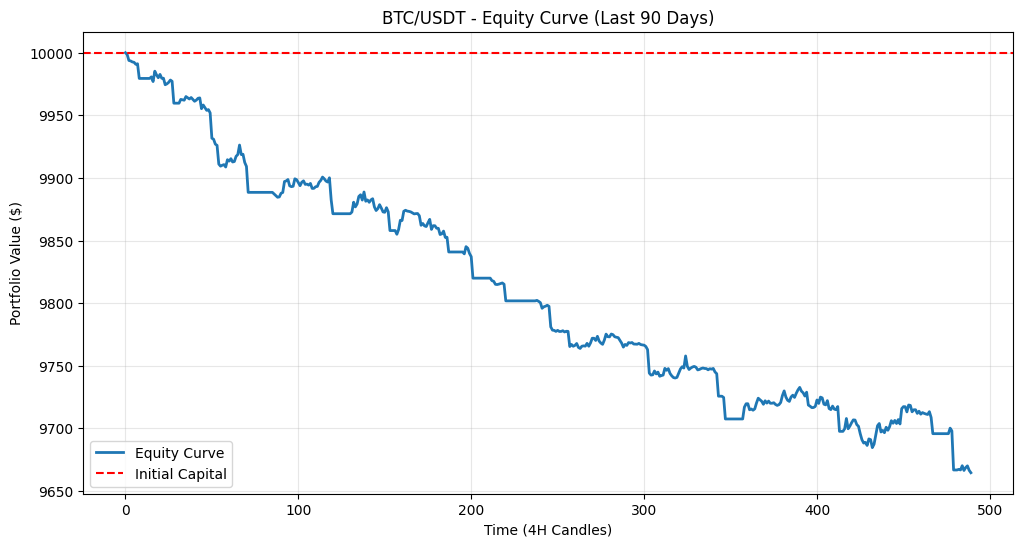

✅ Completed backtest for BTC/USDT

🎯 Starting backtest for ETH/USDT...

🔬 BACKTESTING ETH/USDT - Last 90 days
📊 Fetched 540 candles for ETH/USDT (4h)
✅ Successfully added indicators for 540 candles
📈 Running backtest on 540 candles...
📊 BACKTEST RESULTS for ETH/USDT
   Period: 2025-07-25 to 2025-10-23
   Initial Capital: $10,000.00
   Final Capital: $9,777.08
   Total P&L: $-222.92 (-2.23%)
   Total Trades: 24
   Winning Trades: 10
   Win Rate: 41.7%
   Average Win: $31.62
   Average Loss: $-21.58
   Profit Factor: 1.05
   Max Drawdown: 2.63%

📈 TRADE ANALYSIS BY SIGNAL TYPE:
   TREND_OBV_BEARISH: 8 trades, 50.0% win rate, P&L: $10.31
   TREND_OBV_BULLISH: 14 trades, 35.7% win rate, P&L: $-44.90
   OBV_BULLISH_DIVERGENCE: 1 trades, 100.0% win rate, P&L: $64.44
   OBV_BEARISH_DIVERGENCE: 1 trades, 0.0% win rate, P&L: $-15.80


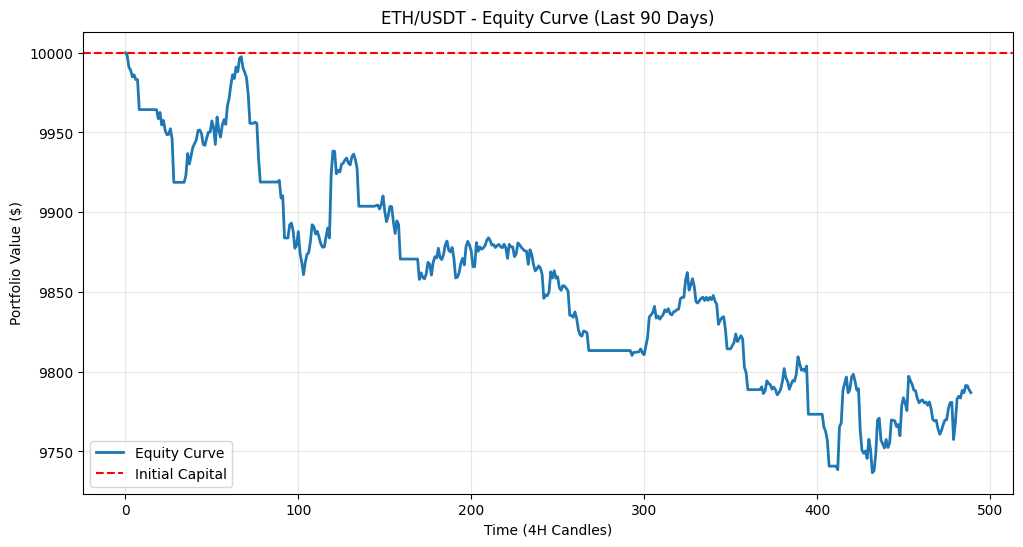

✅ Completed backtest for ETH/USDT

🎯 Starting backtest for ADA/USDT...

🔬 BACKTESTING ADA/USDT - Last 90 days
📊 Fetched 540 candles for ADA/USDT (4h)
✅ Successfully added indicators for 540 candles
📈 Running backtest on 540 candles...
📊 BACKTEST RESULTS for ADA/USDT
   Period: 2025-07-25 to 2025-10-23
   Initial Capital: $10,000.00
   Final Capital: $9,706.17
   Total P&L: $-293.83 (-2.94%)
   Total Trades: 20
   Winning Trades: 6
   Win Rate: 30.0%
   Average Win: $50.66
   Average Loss: $-28.66
   Profit Factor: 0.76
   Max Drawdown: 3.56%

📈 TRADE ANALYSIS BY SIGNAL TYPE:
   TREND_OBV_BEARISH: 11 trades, 27.3% win rate, P&L: $-51.56
   TREND_OBV_BULLISH: 9 trades, 33.3% win rate, P&L: $-45.75


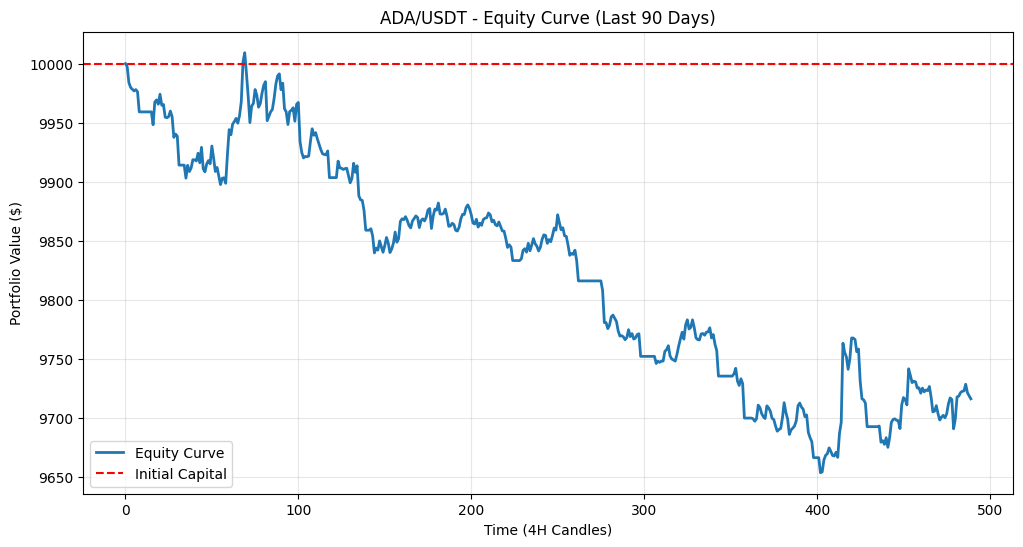

✅ Completed backtest for ADA/USDT

🎯 Starting backtest for SOL/USDT...

🔬 BACKTESTING SOL/USDT - Last 90 days
📊 Fetched 540 candles for SOL/USDT (4h)
✅ Successfully added indicators for 540 candles
📈 Running backtest on 540 candles...
📊 BACKTEST RESULTS for SOL/USDT
   Period: 2025-07-25 to 2025-10-23
   Initial Capital: $10,000.00
   Final Capital: $9,730.55
   Total P&L: $-269.45 (-2.69%)
   Total Trades: 21
   Winning Trades: 8
   Win Rate: 38.1%
   Average Win: $39.45
   Average Loss: $-29.16
   Profit Factor: 0.83
   Max Drawdown: 3.14%

📈 TRADE ANALYSIS BY SIGNAL TYPE:
   TREND_OBV_BEARISH: 9 trades, 33.3% win rate, P&L: $-46.23
   OBV_BEARISH_DIVERGENCE: 3 trades, 33.3% win rate, P&L: $-13.55
   TREND_OBV_BULLISH: 9 trades, 44.4% win rate, P&L: $-3.69


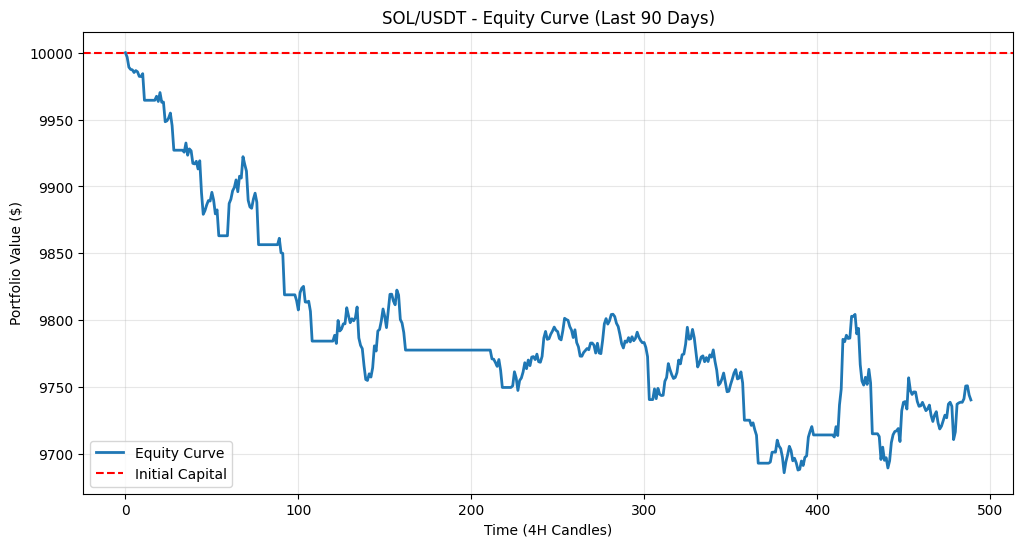

✅ Completed backtest for SOL/USDT

🎯 Starting backtest for XRP/USDT...

🔬 BACKTESTING XRP/USDT - Last 90 days
📊 Fetched 540 candles for XRP/USDT (4h)
✅ Successfully added indicators for 540 candles
📈 Running backtest on 540 candles...
📊 BACKTEST RESULTS for XRP/USDT
   Period: 2025-07-25 to 2025-10-23
   Initial Capital: $10,000.00
   Final Capital: $9,648.05
   Total P&L: $-351.95 (-3.52%)
   Total Trades: 20
   Winning Trades: 6
   Win Rate: 30.0%
   Average Win: $27.47
   Average Loss: $-22.97
   Profit Factor: 0.51
   Max Drawdown: 4.16%

📈 TRADE ANALYSIS BY SIGNAL TYPE:
   TREND_OBV_BEARISH: 13 trades, 46.2% win rate, P&L: $-33.75
   TREND_OBV_BULLISH: 5 trades, 0.0% win rate, P&L: $-89.47
   OBV_BEARISH_DIVERGENCE: 2 trades, 0.0% win rate, P&L: $-33.57


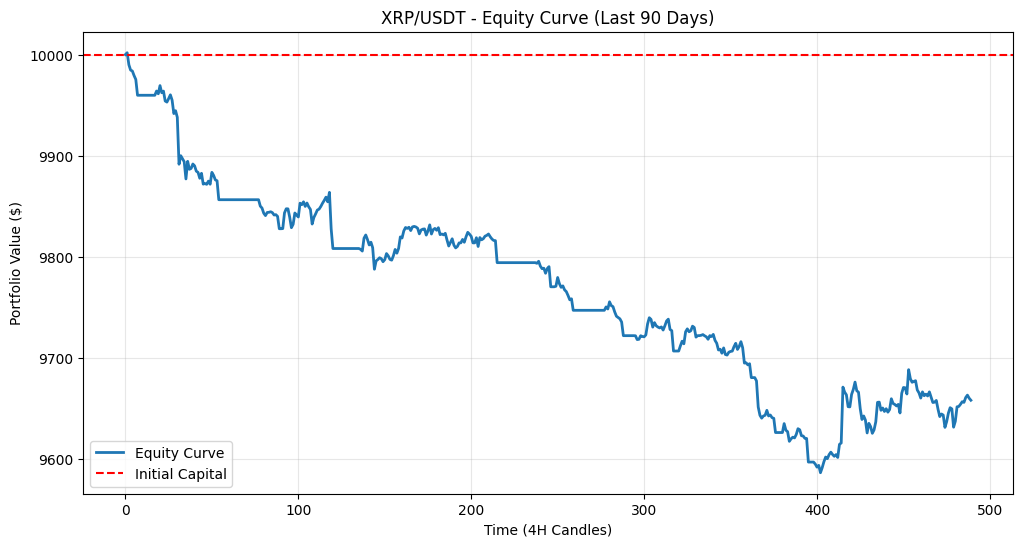

✅ Completed backtest for XRP/USDT

🎯 OVERALL BACKTEST SUMMARY
  Symbol  ROI % Win Rate  Total Trades Profit Factor Max DD Total P&L
BTC/USDT -3.45%    29.6%            27          0.64  3.35%  $-345.10
ETH/USDT -2.23%    41.7%            24          1.05  2.63%  $-222.92
ADA/USDT -2.94%    30.0%            20          0.76  3.56%  $-293.83
SOL/USDT -2.69%    38.1%            21          0.83  3.14%  $-269.45
XRP/USDT -3.52%    30.0%            20          0.51  4.16%  $-351.95

📈 OVERALL AVERAGES:
   Average ROI: -2.97%
   Average Win Rate: 33.9%
   Total Trades Across All Symbols: 112
   Total P&L Across All Symbols: $-1,483.25


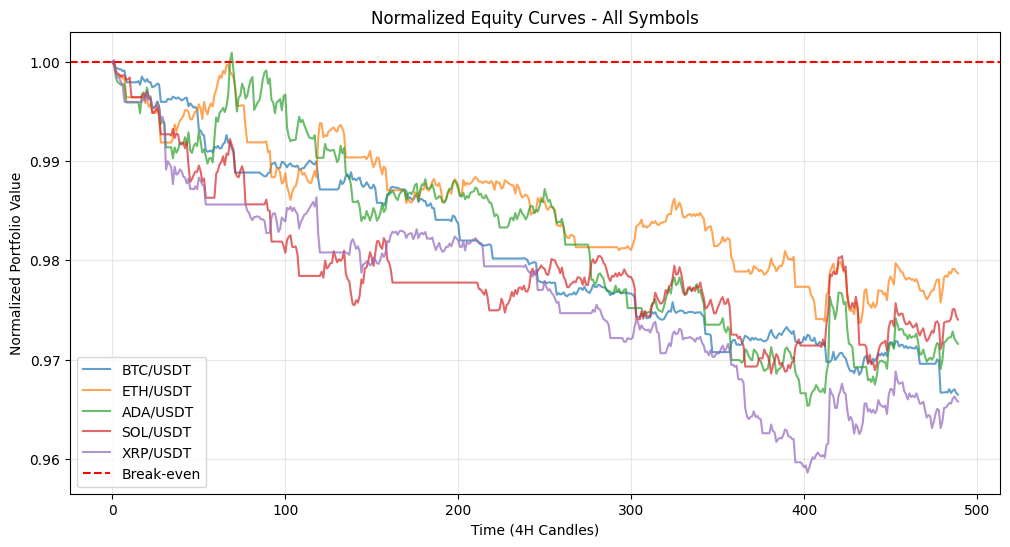

In [9]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import ccxt
import logging
import time
from datetime import datetime, timedelta
import warnings
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Initialize Exchange
exchange = ccxt.kucoin({
    'rateLimit': 100,
    'enableRateLimit': True,
    'timeout': 30000,
})

class Backtest4HTradingStrategy:
    def __init__(self, initial_capital=10000):
        self.initial_capital = initial_capital
        self.commission = 0.001

    def fetch_historical_data_for_backtest(self, symbol, timeframe='4h', days=90):
        """Fetch historical data for backtesting."""
        try:
            since = exchange.parse8601((datetime.now() - timedelta(days=days)).isoformat())
            all_ohlcv = []

            current_since = since
            for _ in range(30):
                try:
                    ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since=current_since, limit=1000)
                    if not ohlcv:
                        break

                    all_ohlcv.extend(ohlcv)
                    current_since = ohlcv[-1][0] + 1
                    time.sleep(0.1)

                    if len(all_ohlcv) >= 500:
                        break

                except Exception as e:
                    break

            if not all_ohlcv:
                return pd.DataFrame()

            df = pd.DataFrame(all_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            df.set_index('timestamp', inplace=True)
            df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].astype(float)

            df = df[~df.index.duplicated(keep='first')]
            df = df.sort_index()

            print(f"📊 Fetched {len(df)} candles for {symbol} ({timeframe})")
            return df

        except Exception as e:
            logging.error(f"Error fetching data for {symbol}: {e}")
            return pd.DataFrame()

    def safe_ta_indicator(self, func, *args, **kwargs):
        """Safely calculate technical indicators with error handling."""
        try:
            result = func(*args, **kwargs)
            return result
        except Exception as e:
            logging.warning(f"Indicator calculation failed: {e}")
            return None

    def add_indicators_for_backtest(self, df):
        """Add indicators for backtesting with proper error handling."""
        if df.empty or len(df) < 50:
            return df

        try:
            # Basic EMAs
            df['EMA_20'] = ta.ema(df['close'], length=20)
            df['EMA_50'] = ta.ema(df['close'], length=50)
            df['EMA_100'] = ta.ema(df['close'], length=100)

            # RSI
            df['RSI'] = ta.rsi(df['close'], length=14)

            # MACD - handle column names properly
            macd = ta.macd(df['close'])
            if macd is not None:
                # Get the first available MACD column
                macd_columns = [col for col in macd.columns if 'MACD' in col]
                if len(macd_columns) >= 3:
                    df['MACD'] = macd[macd_columns[0]]
                    df['MACD_Signal'] = macd[macd_columns[1]]
                    df['MACD_Histogram'] = macd[macd_columns[2]]

            # ATR and Volatility
            atr_result = ta.atr(df['high'], df['low'], df['close'], length=14)
            if atr_result is not None:
                df['ATR'] = atr_result
                df['ATR_pct'] = (df['ATR'] / df['close']) * 100

            # Bollinger Bands - handle column names properly
            bb = ta.bbands(df['close'], length=20)
            if bb is not None:
                # Get available BB columns
                bb_columns = list(bb.columns)
                if len(bb_columns) >= 3:
                    df['BB_upper'] = bb[bb_columns[0]]
                    df['BB_middle'] = bb[bb_columns[1]]
                    df['BB_lower'] = bb[bb_columns[2]]

                    # Calculate derived BB indicators
                    if 'BB_upper' in df.columns and 'BB_lower' in df.columns and 'BB_middle' in df.columns:
                        df['BB_width'] = (df['BB_upper'] - df['BB_lower']) / df['BB_middle']
                        df['BB_position'] = (df['close'] - df['BB_lower']) / (df['BB_upper'] - df['BB_lower'])
                        df['BB_squeeze'] = df['BB_width'] < df['BB_width'].rolling(50, min_periods=1).mean()

            # OBV with proper error handling
            obv_result = ta.obv(df['close'], df['volume'])
            if obv_result is not None:
                df['OBV'] = obv_result

                # OBV EMAs
                obv_ema_20 = ta.ema(df['OBV'], length=20)
                obv_ema_50 = ta.ema(df['OBV'], length=50)

                if obv_ema_20 is not None:
                    df['OBV_EMA_20'] = obv_ema_20
                if obv_ema_50 is not None:
                    df['OBV_EMA_50'] = obv_ema_50

                # OBV trend
                if 'OBV_EMA_20' in df.columns and 'OBV_EMA_50' in df.columns:
                    df['OBV_trend'] = np.where(df['OBV_EMA_20'] > df['OBV_EMA_50'], 1, -1)

                # OBV Breakouts
                if 'OBV' in df.columns:
                    df['OBV_high_20'] = df['OBV'].rolling(20, min_periods=1).max()
                    df['OBV_low_20'] = df['OBV'].rolling(20, min_periods=1).min()
                    df['OBV_breakout'] = np.where(df['OBV'] > df['OBV_high_20'].shift(1), 1,
                                                np.where(df['OBV'] < df['OBV_low_20'].shift(1), -1, 0))

            # Volume indicators
            volume_sma = ta.sma(df['volume'], length=20)
            if volume_sma is not None:
                df['volume_sma'] = volume_sma
                df['volume_ratio'] = df['volume'] / df['volume_sma']

            # Fill NaN values with forward/backward fill
            df = df.ffill().bfill()

            # Ensure critical columns exist
            required_columns = ['EMA_20', 'EMA_50', 'EMA_100', 'RSI', 'ATR', 'OBV']
            for col in required_columns:
                if col not in df.columns:
                    if col == 'RSI':
                        df[col] = 50  # Default neutral RSI
                    elif col in ['EMA_20', 'EMA_50', 'EMA_100']:
                        df[col] = df['close']  # Default to close price
                    else:
                        df[col] = 0  # Default zero

            print(f"✅ Successfully added indicators for {len(df)} candles")
            return df

        except Exception as e:
            logging.error(f"Error adding indicators: {e}")
            # Create basic required columns as fallback
            df['EMA_20'] = df['close']
            df['EMA_50'] = df['close']
            df['EMA_100'] = df['close']
            df['RSI'] = 50
            df['ATR'] = df['close'] * 0.01  # 1% default ATR
            df['OBV'] = 0
            return df

    def get_safe_value(self, df, column, default=0, index=-1):
        """Safely get value from DataFrame column."""
        if df is None or df.empty or column not in df.columns:
            return default
        try:
            value = df[column].iloc[index]
            if pd.isna(value):
                return default
            return value
        except:
            return default

    def generate_signal(self, df, i):
        """Generate trading signal for a specific candle."""
        if i < 50:  # Need enough data for indicators
            return None

        current_data = df.iloc[:i+1].copy()
        current_price = self.get_safe_value(current_data, 'close')

        # Get recent values safely
        ema_20 = self.get_safe_value(current_data, 'EMA_20', current_price)
        ema_50 = self.get_safe_value(current_data, 'EMA_50', current_price)
        obv_trend = self.get_safe_value(current_data, 'OBV_trend', 0)
        obv_ema_20 = self.get_safe_value(current_data, 'OBV_EMA_20', 0)
        obv_ema_50 = self.get_safe_value(current_data, 'OBV_EMA_50', 0)
        volume_ratio = self.get_safe_value(current_data, 'volume_ratio', 1)

        # 1. Trend with OBV Confirmation
        if (current_price > ema_20 > ema_50 and
            obv_trend > 0 and
            obv_ema_20 > obv_ema_50):

            confidence = 0.75
            if volume_ratio > 1.2:
                confidence = min(0.95, confidence + 0.1)

            return ('LONG', confidence, 'TREND_OBV_BULLISH')

        # Bearish Trend with OBV
        elif (current_price < ema_20 < ema_50 and
              obv_trend < 0 and
              obv_ema_20 < obv_ema_50):

            confidence = 0.75
            if volume_ratio > 1.2:
                confidence = min(0.95, confidence + 0.1)

            return ('SHORT', confidence, 'TREND_OBV_BEARISH')

        # 2. Volatility Breakout with OBV
        bb_squeeze = self.get_safe_value(current_data, 'BB_squeeze', False)
        bb_position = self.get_safe_value(current_data, 'BB_position', 0.5)
        obv_breakout = self.get_safe_value(current_data, 'OBV_breakout', 0)

        if bb_squeeze:
            # Bullish breakout
            if (bb_position > 0.7 and obv_breakout > 0 and volume_ratio > 1.5):
                confidence = 0.80
                return ('LONG', confidence, 'VOL_BREAKOUT_BULLISH')

            # Bearish breakout
            elif (bb_position < 0.3 and obv_breakout < 0 and volume_ratio > 1.5):
                confidence = 0.80
                return ('SHORT', confidence, 'VOL_BREAKOUT_BEARISH')

        # 3. OBV Divergence (simplified)
        if len(current_data) >= 15:
            try:
                # Look for basic divergence
                recent_lows = current_data['low'].tail(10)
                recent_obv = current_data['OBV'].tail(10)

                # Bullish divergence: price makes lower low, OBV makes higher low
                if (len(recent_lows) >= 3 and
                    recent_lows.iloc[-1] < recent_lows.iloc[-3] and
                    recent_obv.iloc[-1] > recent_obv.iloc[-3]):

                    rsi = self.get_safe_value(current_data, 'RSI', 50)
                    if rsi < 40:
                        return ('LONG', 0.70, 'OBV_BULLISH_DIVERGENCE')

                # Bearish divergence: price makes higher high, OBV makes lower high
                recent_highs = current_data['high'].tail(10)
                if (len(recent_highs) >= 3 and
                    recent_highs.iloc[-1] > recent_highs.iloc[-3] and
                    recent_obv.iloc[-1] < recent_obv.iloc[-3]):

                    rsi = self.get_safe_value(current_data, 'RSI', 50)
                    if rsi > 60:
                        return ('SHORT', 0.70, 'OBV_BEARISH_DIVERGENCE')
            except:
                pass  # Skip divergence if there's any error

        return None

    def run_backtest(self, symbol, days=90):
        """Run complete backtest for a symbol."""
        print(f"\n🔬 BACKTESTING {symbol} - Last {days} days")
        print("=" * 80)

        # Fetch data
        df = self.fetch_historical_data_for_backtest(symbol, '4h', days)
        if df.empty:
            print(f"❌ No data for {symbol}")
            return None

        # Add indicators
        df = self.add_indicators_for_backtest(df)
        if df.empty:
            print(f"❌ Failed to add indicators for {symbol}")
            return None

        # Backtest parameters
        capital = self.initial_capital
        position = 0
        entry_price = 0
        entry_time = None
        entry_signal_type = None
        trades = []
        winning_trades = 0
        total_trades = 0

        # Track performance
        equity_curve = []
        max_drawdown = 0
        peak_equity = capital

        print(f"📈 Running backtest on {len(df)} candles...")

        for i in range(50, len(df)):  # Start from 50 for indicator stability
            current_price = self.get_safe_value(df, 'close', index=i)
            current_time = df.index[i]

            # Generate signal
            signal = self.generate_signal(df, i)

            # If we have a position, check exit conditions
            if position != 0:
                atr = self.get_safe_value(df, 'ATR', current_price * 0.02, i)

                if position > 0:  # LONG position
                    # Take profit at 3x ATR, stop loss at 2x ATR
                    profit_target = entry_price + (atr * 3)
                    stop_loss = entry_price - (atr * 2)

                    if current_price >= profit_target or current_price <= stop_loss:
                        # Close position
                        pnl = (current_price - entry_price) * position
                        capital += pnl
                        capital -= capital * self.commission  # Commission

                        trade_result = 'WIN' if pnl > 0 else 'LOSS'
                        if trade_result == 'WIN':
                            winning_trades += 1

                        trades.append({
                            'entry_time': entry_time,
                            'exit_time': current_time,
                            'direction': 'LONG',
                            'entry_price': entry_price,
                            'exit_price': current_price,
                            'pnl': pnl,
                            'result': trade_result,
                            'signal_type': entry_signal_type
                        })

                        position = 0
                        total_trades += 1
                        entry_signal_type = None

                elif position < 0:  # SHORT position
                    # Take profit at 3x ATR, stop loss at 2x ATR
                    profit_target = entry_price - (atr * 3)
                    stop_loss = entry_price + (atr * 2)

                    if current_price <= profit_target or current_price >= stop_loss:
                        # Close position (for short: profit when price goes down)
                        pnl = (entry_price - current_price) * abs(position)
                        capital += pnl
                        capital -= capital * self.commission  # Commission

                        trade_result = 'WIN' if pnl > 0 else 'LOSS'
                        if trade_result == 'WIN':
                            winning_trades += 1

                        trades.append({
                            'entry_time': entry_time,
                            'exit_time': current_time,
                            'direction': 'SHORT',
                            'entry_price': entry_price,
                            'exit_price': current_price,
                            'pnl': pnl,
                            'result': trade_result,
                            'signal_type': entry_signal_type
                        })

                        position = 0
                        total_trades += 1
                        entry_signal_type = None

            # If no position and we have a high-confidence signal, enter trade
            if position == 0 and signal and signal[1] >= 0.7:  # Minimum 70% confidence
                direction, confidence, signal_type = signal
                atr = self.get_safe_value(df, 'ATR', current_price * 0.02, i)

                # Calculate position size (2% risk per trade)
                risk_amount = capital * 0.02
                if direction == 'LONG':
                    stop_loss = current_price - (atr * 2)
                    price_risk = current_price - stop_loss
                else:
                    stop_loss = current_price + (atr * 2)
                    price_risk = stop_loss - current_price

                if price_risk > 0:
                    position_size = risk_amount / price_risk
                    # Don't risk more than 5% of capital
                    max_position = (capital * 0.05) / current_price
                    position_size = min(position_size, max_position)

                    if direction == 'LONG':
                        position = position_size
                    else:
                        position = -position_size

                    entry_price = current_price
                    entry_time = current_time
                    entry_signal_type = signal_type

            # Update equity curve and drawdown
            current_equity = capital
            if position != 0:
                if position > 0:
                    current_equity += (current_price - entry_price) * position
                else:
                    current_equity += (entry_price - current_price) * abs(position)

            equity_curve.append(current_equity)
            peak_equity = max(peak_equity, current_equity)
            drawdown = (peak_equity - current_equity) / peak_equity if peak_equity > 0 else 0
            max_drawdown = max(max_drawdown, drawdown)

        # Close any open position at the end
        if position != 0:
            current_price = self.get_safe_value(df, 'close', index=-1)
            if position > 0:
                pnl = (current_price - entry_price) * position
            else:
                pnl = (entry_price - current_price) * abs(position)

            capital += pnl
            capital -= capital * self.commission

            trade_result = 'WIN' if pnl > 0 else 'LOSS'
            if trade_result == 'WIN':
                winning_trades += 1

            trades.append({
                'entry_time': entry_time,
                'exit_time': df.index[-1],
                'direction': 'LONG' if position > 0 else 'SHORT',
                'entry_price': entry_price,
                'exit_price': current_price,
                'pnl': pnl,
                'result': trade_result,
                'signal_type': entry_signal_type
            })

            total_trades += 1

        # Calculate performance metrics
        win_rate = (winning_trades / total_trades * 100) if total_trades > 0 else 0
        total_pnl = capital - self.initial_capital
        roi = (total_pnl / self.initial_capital) * 100

        # Calculate additional metrics
        if trades:
            winning_pnls = [t['pnl'] for t in trades if t['result'] == 'WIN']
            losing_pnls = [t['pnl'] for t in trades if t['result'] == 'LOSS']

            avg_win = np.mean(winning_pnls) if winning_pnls else 0
            avg_loss = np.mean(losing_pnls) if losing_pnls else 0
            profit_factor = abs(sum(winning_pnls) / sum(losing_pnls)) if losing_pnls and sum(losing_pnls) != 0 else float('inf')
        else:
            avg_win = avg_loss = profit_factor = 0

        # Display results
        print(f"📊 BACKTEST RESULTS for {symbol}")
        print(f"   Period: {df.index[0].strftime('%Y-%m-%d')} to {df.index[-1].strftime('%Y-%m-%d')}")
        print(f"   Initial Capital: ${self.initial_capital:,.2f}")
        print(f"   Final Capital: ${capital:,.2f}")
        print(f"   Total P&L: ${total_pnl:,.2f} ({roi:.2f}%)")
        print(f"   Total Trades: {total_trades}")
        print(f"   Winning Trades: {winning_trades}")
        print(f"   Win Rate: {win_rate:.1f}%")
        print(f"   Average Win: ${avg_win:.2f}")
        print(f"   Average Loss: ${avg_loss:.2f}")
        print(f"   Profit Factor: {profit_factor:.2f}")
        print(f"   Max Drawdown: {max_drawdown*100:.2f}%")

        # Trade analysis by signal type
        if trades:
            print(f"\n📈 TRADE ANALYSIS BY SIGNAL TYPE:")
            signal_stats = {}
            for trade in trades:
                signal_type = trade['signal_type']
                if signal_type not in signal_stats:
                    signal_stats[signal_type] = {'wins': 0, 'total': 0, 'pnl': 0}

                signal_stats[signal_type]['total'] += 1
                signal_stats[signal_type]['pnl'] += trade['pnl']
                if trade['result'] == 'WIN':
                    signal_stats[signal_type]['wins'] += 1

            for signal_type, stats in signal_stats.items():
                win_rate_signal = (stats['wins'] / stats['total'] * 100) if stats['total'] > 0 else 0
                print(f"   {signal_type}: {stats['total']} trades, {win_rate_signal:.1f}% win rate, P&L: ${stats['pnl']:.2f}")

        # Plot equity curve
        if len(equity_curve) > 0:
            plt.figure(figsize=(12, 6))
            plt.plot(equity_curve, label='Equity Curve', linewidth=2)
            plt.axhline(y=self.initial_capital, color='r', linestyle='--', label='Initial Capital')
            plt.title(f'{symbol} - Equity Curve (Last {days} Days)')
            plt.xlabel('Time (4H Candles)')
            plt.ylabel('Portfolio Value ($)')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()

        print("=" * 80)

        return {
            'symbol': symbol,
            'initial_capital': self.initial_capital,
            'final_capital': capital,
            'total_pnl': total_pnl,
            'roi': roi,
            'total_trades': total_trades,
            'winning_trades': winning_trades,
            'win_rate': win_rate,
            'avg_win': avg_win,
            'avg_loss': avg_loss,
            'profit_factor': profit_factor,
            'max_drawdown': max_drawdown,
            'trades': trades,
            'equity_curve': equity_curve
        }

# Run comprehensive backtest
if __name__ == "__main__":
    backtester = Backtest4HTradingStrategy(initial_capital=10000)

    symbols = ['BTC/USDT', 'ETH/USDT', 'ADA/USDT', 'SOL/USDT', 'XRP/USDT']

    print("🚀 COMPREHENSIVE 4H TRADING STRATEGY BACKTEST")
    print("Testing period: Last 90 days (3 months)")
    print("=" * 80)

    results = {}

    for symbol in symbols:
        try:
            print(f"\n🎯 Starting backtest for {symbol}...")
            result = backtester.run_backtest(symbol, days=90)
            if result:
                results[symbol] = result
                print(f"✅ Completed backtest for {symbol}")
            time.sleep(2)  # Rate limiting between symbols
        except Exception as e:
            print(f"❌ Error backtesting {symbol}: {e}")
            continue

    # Display summary
    if results:
        print("\n" + "=" * 80)
        print("🎯 OVERALL BACKTEST SUMMARY")
        print("=" * 80)

        summary_data = []
        for symbol, result in results.items():
            summary_data.append({
                'Symbol': symbol,
                'ROI %': f"{result['roi']:.2f}%",
                'Win Rate': f"{result['win_rate']:.1f}%",
                'Total Trades': result['total_trades'],
                'Profit Factor': f"{result['profit_factor']:.2f}",
                'Max DD': f"{result['max_drawdown']*100:.2f}%",
                'Total P&L': f"${result['total_pnl']:,.2f}"
            })

        summary_df = pd.DataFrame(summary_data)
        print(summary_df.to_string(index=False))

        # Calculate overall statistics
        total_roi = sum(result['roi'] for result in results.values()) / len(results)
        avg_win_rate = sum(result['win_rate'] for result in results.values()) / len(results)
        total_trades_all = sum(result['total_trades'] for result in results.values())
        total_pnl_all = sum(result['total_pnl'] for result in results.values())

        print(f"\n📈 OVERALL AVERAGES:")
        print(f"   Average ROI: {total_roi:.2f}%")
        print(f"   Average Win Rate: {avg_win_rate:.1f}%")
        print(f"   Total Trades Across All Symbols: {total_trades_all}")
        print(f"   Total P&L Across All Symbols: ${total_pnl_all:,.2f}")

        # Plot combined equity curve
        plt.figure(figsize=(12, 6))
        for symbol, result in results.items():
            if len(result['equity_curve']) > 0:
                normalized_equity = [equity / result['initial_capital'] for equity in result['equity_curve']]
                plt.plot(normalized_equity, label=symbol, alpha=0.7)

        plt.axhline(y=1, color='r', linestyle='--', label='Break-even')
        plt.title('Normalized Equity Curves - All Symbols')
        plt.xlabel('Time (4H Candles)')
        plt.ylabel('Normalized Portfolio Value')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    else:
        print("❌ No successful backtests completed")